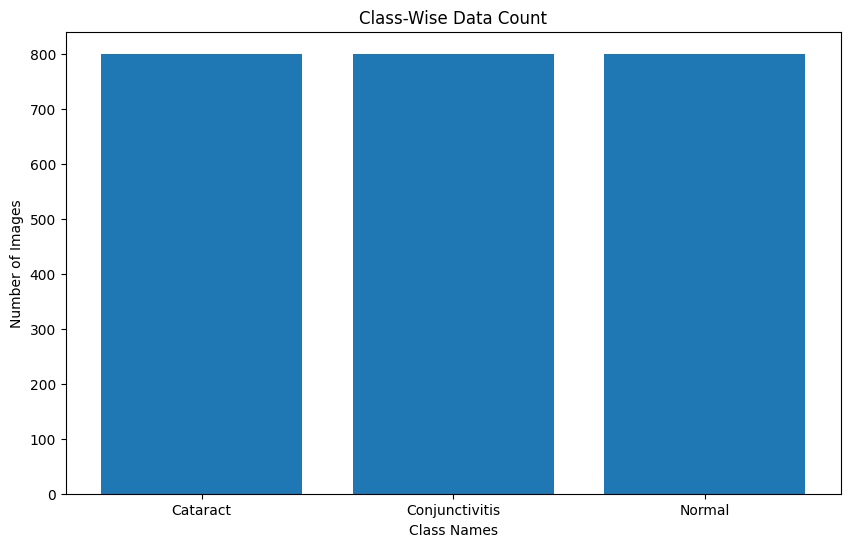

Found 1920 images belonging to 3 classes.
Found 480 images belonging to 3 classes.


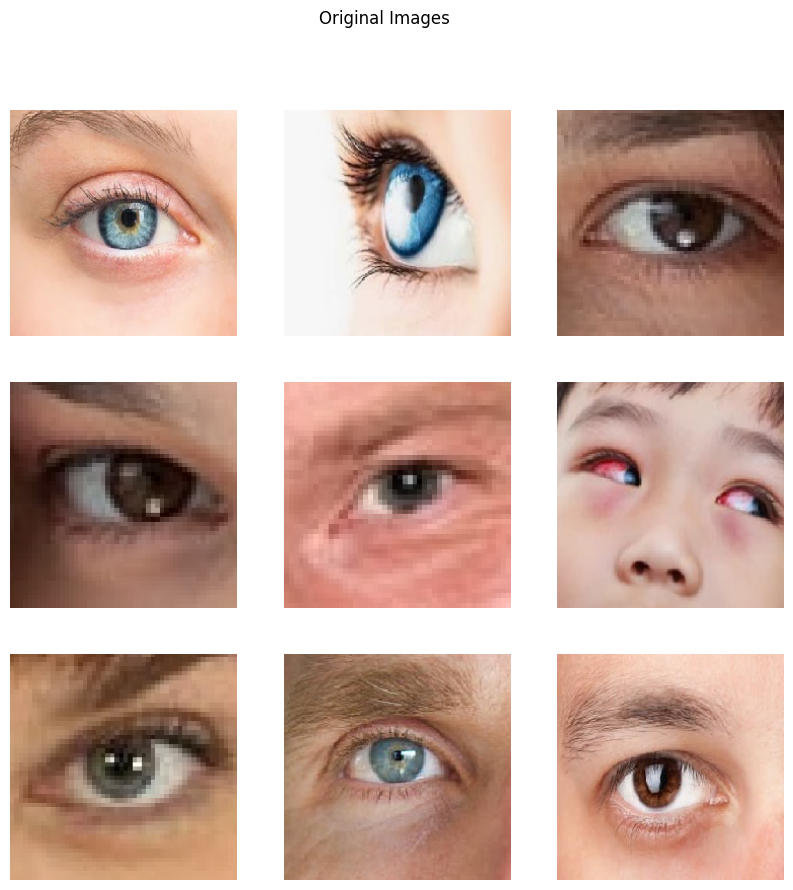

Found 2400 images belonging to 3 classes.


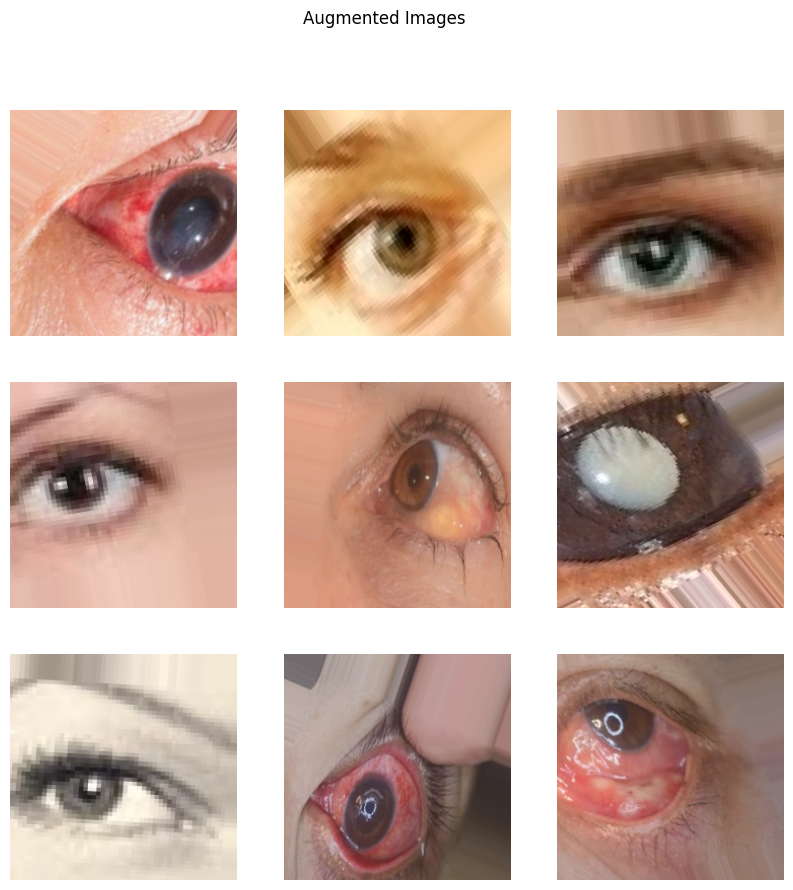

Training fold 1...


Epoch 1/20


48/48 [==============================] - 167s 3s/step - loss: 0.8629 - accuracy: 0.8483 - val_loss: 0.2133 - val_accuracy: 0.9453
Epoch 2/20
48/48 [==============================] - 111s 2s/step - loss: 0.1640 - accuracy: 0.9583 - val_loss: 0.1401 - val_accuracy: 0.9661
Epoch 3/20
48/48 [==============================] - 93s 2s/step - loss: 0.0420 - accuracy: 0.9863 - val_loss: 0.1189 - val_accuracy: 0.9740
Epoch 4/20
48/48 [==============================] - 83s 2s/step - loss: 0.0322 - accuracy: 0.9889 - val_loss: 0.1588 - val_accuracy: 0.9635
Epoch 5/20
48/48 [==============================] - 89s 2s/step - loss: 0.0242 - accuracy: 0.9902 - val_loss: 0.1676 - val_accuracy: 0.9635
Epoch 6/20
48/48 [==============================] - 93s 2s/step - loss: 0.0119 - accuracy: 0.9954 - val_loss: 0.1215 - val_accuracy: 0.9740
Epoch 7/20
48/48 [==============================] - 104s 2s/step - loss: 0.0114 - accuracy: 0.9961 - val_loss: 0.2115 - val_accuracy: 0

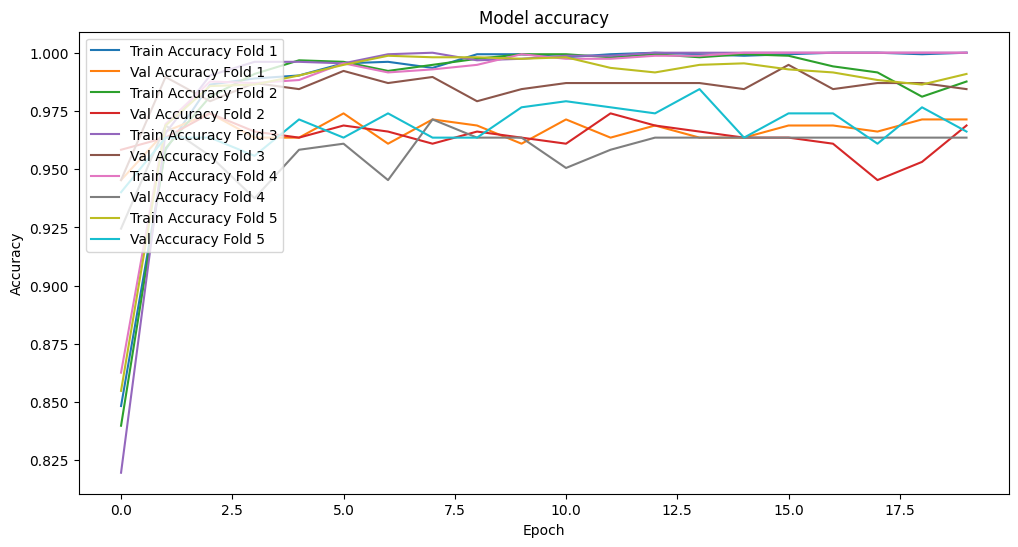

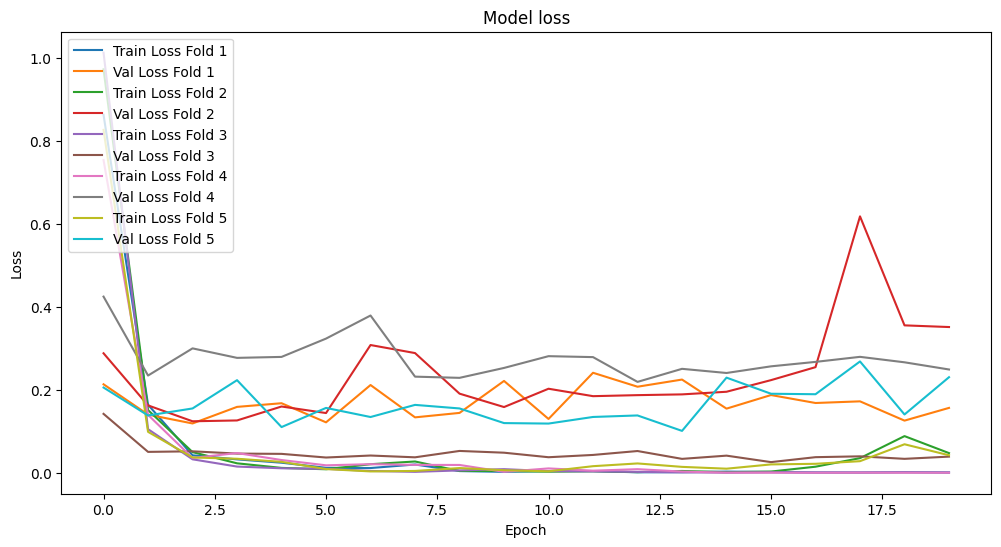

Average Validation Accuracy: 0.9708333373069763
Validation Accuracies for each fold: [0.9713541865348816, 0.96875, 0.984375, 0.9635416865348816, 0.9661458134651184]
Average TPR: [0.9876444  0.95962352 0.96607042]
Average TNR: [0.97570878 0.98778525 0.99291683]
Average FPR: [0.02429122 0.01221475 0.00708317]
Average FNR: [0.0123556  0.04037648 0.03392958]
Found 480 images belonging to 3 classes.
16/16 [==============================] - 11s 621ms/step
Test Classification Report:
                precision    recall  f1-score   support

      Cataract       0.35      0.37      0.36       160
Conjunctivitis       0.31      0.30      0.31       160
        Normal       0.39      0.39      0.39       160

      accuracy                           0.35       480
     macro avg       0.35      0.35      0.35       480
  weighted avg       0.35      0.35      0.35       480

Test Confusion Matrix:
[[59 58 43]
 [58 48 54]
 [51 47 62]]
Test TPR: [0.36875 0.3     0.3875 ]
Test TNR: [0.659375 0.67187

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
import os

dataset_dir = 'D:\\Eye\\Eye Research\\Dataset Collected\\CCN'

class_counts = {}
for subdir, dirs, files in os.walk(dataset_dir):
    for dir in dirs:
        class_counts[dir] = len(os.listdir(os.path.join(subdir, dir)))

plt.figure(figsize=(10, 6))
plt.bar(class_counts.keys(), class_counts.values())
plt.title('Class-Wise Data Count')
plt.xlabel('Class Names')
plt.ylabel('Number of Images')
plt.show()

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    dataset_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    dataset_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    subset='validation'
)

augmented_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

def plot_images(generator, title):
    sample_images, _ = next(generator)
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(sample_images[i])
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

plot_images(train_generator, "Original Images")
plot_images(augmented_datagen.flow_from_directory(dataset_dir, target_size=(224, 224), batch_size=32, class_mode='sparse', subset='training'), "Augmented Images")

def create_mobilenetv2_model(input_shape=(224, 224, 3), num_classes=len(class_counts)):
    mobilenet_base = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
    for layer in mobilenet_base.layers:
        layer.trainable = False

    x = Flatten()(mobilenet_base.output)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=mobilenet_base.input, outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

def generator_to_numpy(generator):
    images = []
    labels = []
    for _ in range(len(generator)):
        img, lbl = next(generator)
        images.append(img)
        labels.append(lbl)
    return np.concatenate(images), np.concatenate(labels)

X, y = generator_to_numpy(train_generator)

def calculate_metrics(conf_matrix):
    FP = conf_matrix.sum(axis=0) - np.diag(conf_matrix)  
    FN = conf_matrix.sum(axis=1) - np.diag(conf_matrix)
    TP = np.diag(conf_matrix)
    TN = conf_matrix.sum() - (FP + FN + TP)

    TPR = TP / (TP + FN)
    TNR = TN / (TN + FP)
    FPR = FP / (FP + TN)
    FNR = FN / (FN + TP)

    return TPR, TNR, FPR, FNR

kf = KFold(n_splits=5, shuffle=True, random_state=42)

fold_no = 1
accuracies = []
histories = []
tpr_list = []
tnr_list = []
fpr_list = []
fnr_list = []

for train_index, val_index in kf.split(X):
    print(f"Training fold {fold_no}...")
    
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    model = create_mobilenetv2_model()

    history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val))
    histories.append(history)

    y_val_pred = model.predict(X_val)
    y_val_pred_classes = np.argmax(y_val_pred, axis=1)

    conf_matrix = confusion_matrix(y_val, y_val_pred_classes)
    class_report = classification_report(y_val, y_val_pred_classes, target_names=list(class_counts.keys()))

    TPR, TNR, FPR, FNR = calculate_metrics(conf_matrix)

    tpr_list.append(TPR)
    tnr_list.append(TNR)
    fpr_list.append(FPR)
    fnr_list.append(FNR)

    print(f"Fold {fold_no} - Classification Report:\n{class_report}")
    print(f"Fold {fold_no} - Confusion Matrix:\n{conf_matrix}")
    print(f"Fold {fold_no} - TPR: {TPR}")
    print(f"Fold {fold_no} - TNR: {TNR}")
    print(f"Fold {fold_no} - FPR: {FPR}")
    print(f"Fold {fold_no} - FNR: {FNR}")

    accuracies.append(history.history['val_accuracy'][-1])

    fold_no += 1

plt.figure(figsize=(12, 6))
for i, history in enumerate(histories):
    plt.plot(history.history['accuracy'], label=f'Train Accuracy Fold {i+1}')
    plt.plot(history.history['val_accuracy'], label=f'Val Accuracy Fold {i+1}')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

plt.figure(figsize=(12, 6))
for i, history in enumerate(histories):
    plt.plot(history.history['loss'], label=f'Train Loss Fold {i+1}')
    plt.plot(history.history['val_loss'], label=f'Val Loss Fold {i+1}')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

print(f"Average Validation Accuracy: {np.mean(accuracies)}")
print(f"Validation Accuracies for each fold: {accuracies}")

avg_tpr = np.mean(tpr_list, axis=0)
avg_tnr = np.mean(tnr_list, axis=0)
avg_fpr = np.mean(fpr_list, axis=0)
avg_fnr = np.mean(fnr_list, axis=0)

print(f"Average TPR: {avg_tpr}")
print(f"Average TNR: {avg_tnr}")
print(f"Average FPR: {avg_fpr}")
print(f"Average FNR: {avg_fnr}")

best_fold = np.argmax(accuracies)
best_model = histories[best_fold].model

test_generator = datagen.flow_from_directory(
    dataset_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    subset='validation'
)
test_generator.reset()
y_test = test_generator.classes
y_test_pred = best_model.predict(test_generator, steps=test_generator.n // test_generator.batch_size + 1)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)

conf_matrix_test = confusion_matrix(y_test, y_test_pred_classes)
class_report_test = classification_report(y_test, y_test_pred_classes, target_names=list(class_counts.keys()))

print(f"Test Classification Report:\n{class_report_test}")
print(f"Test Confusion Matrix:\n{conf_matrix_test}")

TPR_test, TNR_test, FPR_test, FNR_test = calculate_metrics(conf_matrix_test)
print(f"Test TPR: {TPR_test}")
print(f"Test TNR: {TNR_test}")
print(f"Test FPR: {FPR_test}")
print(f"Test FNR: {FNR_test}")


Found 2400 images belonging to 3 classes.


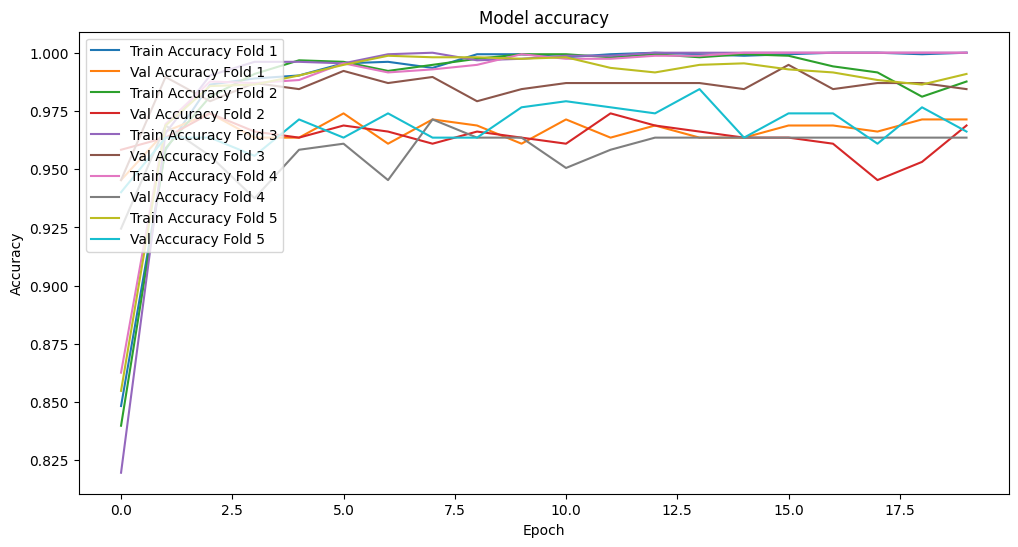

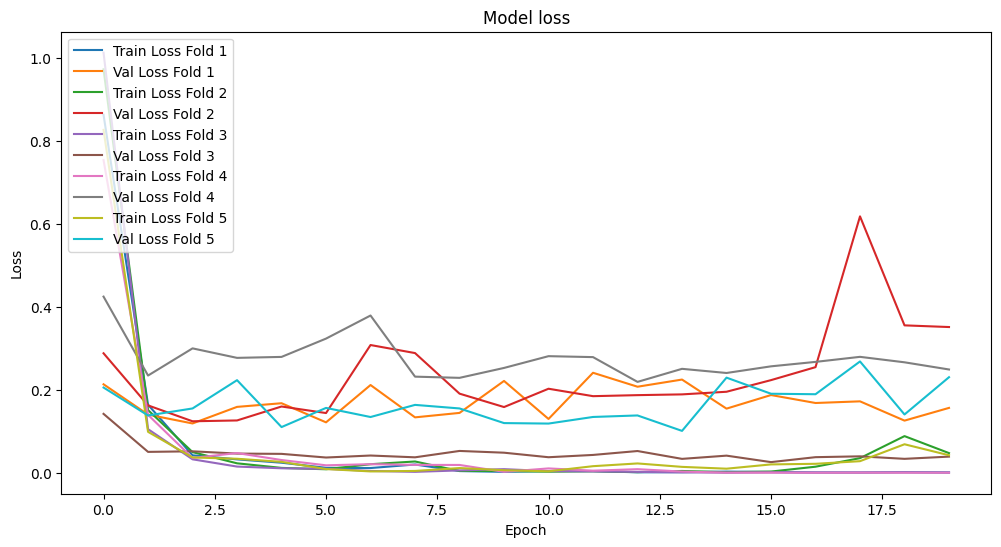

Average Validation Accuracy: 0.9708333373069763
Validation Accuracies for each fold: [0.9713541865348816, 0.96875, 0.984375, 0.9635416865348816, 0.9661458134651184]
Average TPR: [0.9876444  0.95962352 0.96607042]
Average TNR: [0.97570878 0.98778525 0.99291683]
Average FPR: [0.02429122 0.01221475 0.00708317]
Average FNR: [0.0123556  0.04037648 0.03392958]
76/76 [==============================] - 30s 398ms/step
Test Classification Report:
                precision    recall  f1-score   support

      Cataract       0.98      1.00      0.99       800
Conjunctivitis       1.00      0.99      0.99       800
        Normal       1.00      0.99      0.99       800

      accuracy                           0.99      2400
     macro avg       0.99      0.99      0.99      2400
  weighted avg       0.99      0.99      0.99      2400

Test Confusion Matrix:
[[800   0   0]
 [  9 789   2]
 [  6   2 792]]
Test TPR: [1.      0.98625 0.99   ]
Test TNR: [0.990625 0.99875  0.99875 ]
Test FPR: [0.009375 

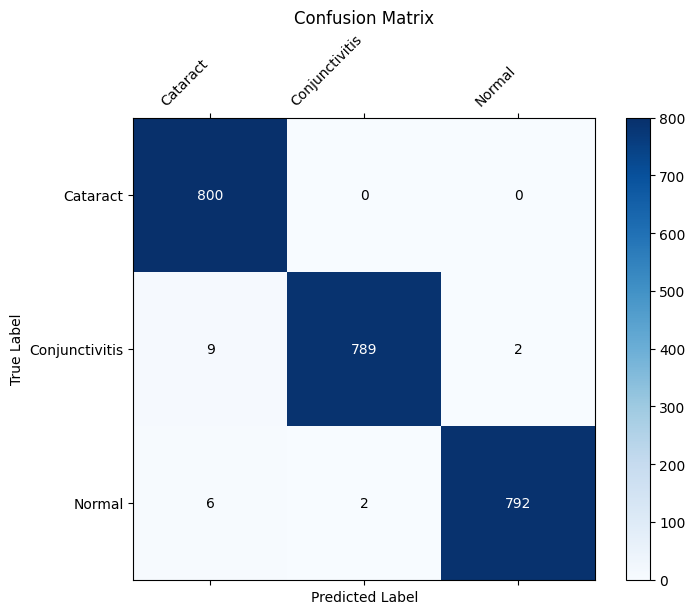

In [4]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    dataset_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    shuffle=False
)

plt.figure(figsize=(12, 6))
for i, history in enumerate(histories):
    plt.plot(history.history['accuracy'], label=f'Train Accuracy Fold {i+1}')
    plt.plot(history.history['val_accuracy'], label=f'Val Accuracy Fold {i+1}')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

plt.figure(figsize=(12, 6))
for i, history in enumerate(histories):
    plt.plot(history.history['loss'], label=f'Train Loss Fold {i+1}')
    plt.plot(history.history['val_loss'], label=f'Val Loss Fold {i+1}')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

print(f"Average Validation Accuracy: {np.mean(accuracies)}")
print(f"Validation Accuracies for each fold: {accuracies}")

avg_tpr = np.mean(tpr_list, axis=0)
avg_tnr = np.mean(tnr_list, axis=0)
avg_fpr = np.mean(fpr_list, axis=0)
avg_fnr = np.mean(fnr_list, axis=0)

print(f"Average TPR: {avg_tpr}")
print(f"Average TNR: {avg_tnr}")
print(f"Average FPR: {avg_fpr}")
print(f"Average FNR: {avg_fnr}")

best_fold = np.argmax(accuracies)
best_model = histories[best_fold].model

test_generator.reset()
y_test = test_generator.classes
y_test_pred = best_model.predict(test_generator, steps=test_generator.n // test_generator.batch_size + 1)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)

conf_matrix_test = confusion_matrix(y_test, y_test_pred_classes)
class_report_test = classification_report(y_test, y_test_pred_classes, target_names=list(class_counts.keys()))

print(f"Test Classification Report:\n{class_report_test}")
print(f"Test Confusion Matrix:\n{conf_matrix_test}")

TPR_test, TNR_test, FPR_test, FNR_test = calculate_metrics(conf_matrix_test)
print(f"Test TPR: {TPR_test}")
print(f"Test TNR: {TNR_test}")
print(f"Test FPR: {FPR_test}")
print(f"Test FNR: {FNR_test}")

def plot_confusion_matrix(cm, class_names):
    """
    Plots the confusion matrix.
    Args:
        cm: confusion matrix
        class_names: list of class names
    """
    fig, ax = plt.subplots(figsize=(8, 6))
    cax = ax.matshow(cm, cmap=plt.cm.Blues)
    fig.colorbar(cax)

    ax.set_xticks(np.arange(len(class_names)))
    ax.set_yticks(np.arange(len(class_names)))
    ax.set_xticklabels(class_names, rotation=45, ha="right")
    ax.set_yticklabels(class_names)

    for i in range(len(class_names)):
        for j in range(len(class_names)):
            ax.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > cm.max() / 2. else "black")

    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(conf_matrix_test, list(class_counts.keys()))